In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

from copy import deepcopy

import gmm_experiments_lib as gmm_lib

import sys
sys.path.insert(0, '../../rb_utils/')
import optimization_lib as optim_lib
import baselines_lib as bs_lib

In [2]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [3]:
np.random.seed(454)
_ = torch.manual_seed(454)

# Draw data

In [4]:
mu0 = torch.Tensor([0, 0])
sigma0 = 8
n_clusters = 10

n_obs = 200

In [5]:
gmm_experiment = gmm_lib.GMMExperiments(n_obs, mu0, sigma0, n_clusters, hidden_dim=200)

Text(0,0.5,' ')

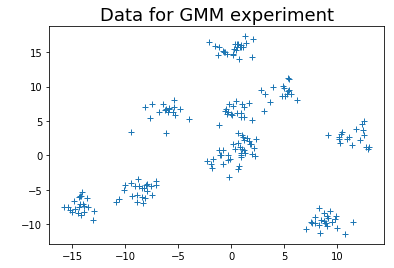

In [6]:
plt.plot(gmm_experiment.y[:, 0].numpy(), gmm_experiment.y[:, 1].numpy(), '+')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), gmm_experiment.true_mus[:, 1].numpy(), 'x')

plt.title('Data for GMM experiment', fontsize = 18)
plt.ylabel(' ')

# Set up marginalization class and run k-means init

In [7]:
gmm_experiment.set_kmeans_init_var_params()
# obj_class_reinforce.experiment_class.set_random_var_params()

k_means_init_params = deepcopy(gmm_experiment.var_params)

In [8]:
# check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = torch.exp(gmm_experiment.get_log_q().detach())

z_ind = np.argmax(class_weights.numpy(), axis = 1)

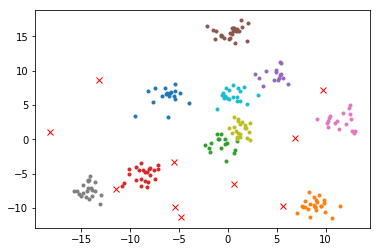

In [9]:
plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


# Train with true gradient

In [10]:
# vb_params_opt, loss_array_true_grad = obj_class_reinforce.run_SGD(alpha=0.0, topk = 1, lr = 1e-2, n_steps=1000, 
#                                                use_true_grad = True)

n_steps = 500
lr = 1e-2

loss_array_true_grad, opt_param = optim_lib.run_SGD(get_loss = gmm_experiment.get_full_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps)

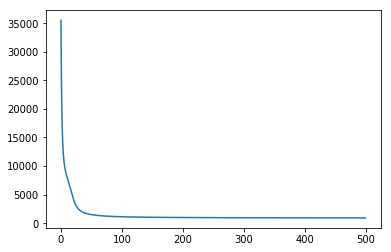

In [11]:
plt.plot(loss_array_true_grad)

In [12]:
print('initial elbo: ', loss_array_true_grad[0])

initial elbo:  35518.15234375


In [13]:
print('final elbo: ', loss_array_true_grad[-1])

final elbo:  917.8703002929688


In [14]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

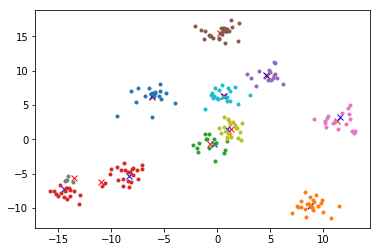

In [15]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

# Is REINFORCE useful at all here?

In [16]:
# Reuse same kmeans init
gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

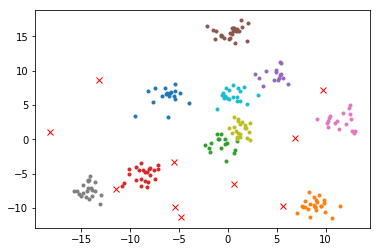

In [17]:
# # check kmeans init
centroids_init = gmm_experiment.var_params['centroids']
class_weights = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))

z_ind = np.argmax(class_weights.numpy(), axis = 1)

plt.figure()

plt.plot(centroids_init[:, 0].detach().numpy(), 
         centroids_init[:, 1].detach().numpy(), 'x', color = 'red')
# plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
#          gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')


In [18]:
class GMMLossClass(object): 
    def __init__(self, gmm_experiment, topk, grad_estimator): 
        self.gmm_experiment = gmm_experiment
        self.topk = topk
        self.grad_estimator = grad_estimator

    def get_loss(self): 
        return self.gmm_experiment.get_pm_loss(topk=self.topk, 
                                           grad_estimator=self.grad_estimator)


In [19]:
gmm_loss_class = GMMLossClass(gmm_experiment, topk = 0, grad_estimator = bs_lib.reinforce)

loss_array_reinforce_bl, opt_param = optim_lib.run_SGD(
                get_loss = gmm_loss_class.get_loss, 
                params = gmm_experiment.var_params,
                lr = lr, 
                n_steps = n_steps, 
                get_full_loss = gmm_experiment.get_full_loss)

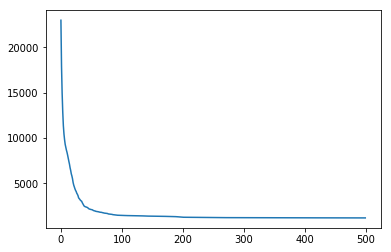

In [20]:
plt.plot(loss_array_reinforce_bl)

In [21]:
print('initial elbo: ', loss_array_reinforce_bl[0])

initial elbo:  22994.146484375


In [22]:
print('final elbo: ', loss_array_reinforce_bl[-1])

final elbo:  1185.208740234375


In [23]:
class_weights_opt = deepcopy(torch.exp(gmm_experiment.get_log_q().detach()))
centroids_opt = opt_param['centroids']
sigma_opt = opt_param['log_sigma']

z_ind = torch.argmax(class_weights_opt, dim=1).numpy()

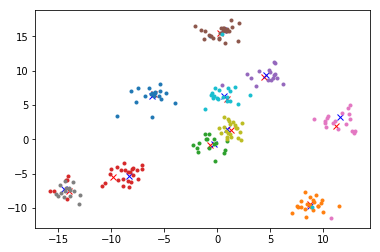

In [24]:
plt.figure()
plt.plot(centroids_opt[:, 0].detach().numpy(), 
         centroids_opt[:, 1].detach().numpy(), 'x', color = 'red')
plt.plot(gmm_experiment.true_mus[:, 0].numpy(), 
         gmm_experiment.true_mus[:, 1].numpy(), 'x', color = 'blue')

for i in range(n_clusters): 
    plt.plot(gmm_experiment.y.numpy()[z_ind == i, 0], 
            gmm_experiment.y.numpy()[z_ind == i, 1], '.')
    

In [28]:
def get_avg_paths(gmm_experiment, k_means_init_params, n_summed, grad_estimator, 
                  n_trials = 20, n_steps = 200, lr = 1): 
    # Function to run a few trials of SGD and get the average path 
    
    loss_path_all = np.zeros((n_trials, n_steps))
    
    for i in range(n_trials): 
        
        gmm_experiment.var_params['free_class_weights'] = deepcopy(k_means_init_params['free_class_weights'])

        gmm_experiment.var_params['centroids'] = deepcopy(k_means_init_params['centroids'])
        gmm_experiment.var_params['log_sigma'] = deepcopy(k_means_init_params['log_sigma'])

        gmm_loss_class = GMMLossClass(gmm_experiment, topk = n_summed, grad_estimator = grad_estimator)

        loss_array_reinforce_bl, opt_param = optim_lib.run_SGD(
                        get_loss = gmm_loss_class.get_loss, 
                        params = gmm_experiment.var_params,
                        lr = lr, 
                        n_steps = n_steps, 
                        get_full_loss = gmm_experiment.get_full_loss)

            
        loss_path_all[i, :] = loss_array_reinforce_bl
    
    loss_array_avg = np.mean(loss_path_all, axis = 0)
    
    return loss_array_avg, loss_path_all


0
1
2
3
10


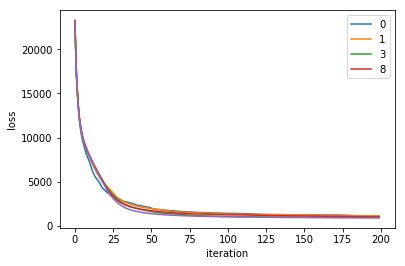

In [30]:
n_steps = 200

n_summed_array = [0, 1, 2, 3, 10]

avg_loss_num_reinforce_array = np.zeros((len(n_summed_array), n_steps))

for i in range(len(n_summed_array)): 
    n_summed = n_summed_array[i]
    print(n_summed)
    
    avg_loss_array, _ = \
        get_avg_paths(gmm_experiment, k_means_init_params, n_summed = n_summed, 
                      grad_estimator = bs_lib.reinforce_w_double_sample_baseline, 
                      lr = lr, n_steps = n_steps)
        
    avg_loss_num_reinforce_array[i, :] = avg_loss_array
        
    plt.plot(avg_loss_array, '-')

plt.xlabel('iteration')
plt.ylabel('loss')

plt.legend(('0', '1', '3', '8'))

# plt.plot(optimal_loss.numpy() * np.ones(n_steps), '--')


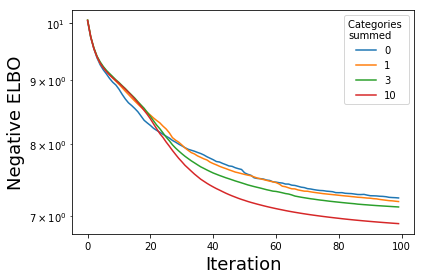

In [32]:
plt.semilogy(np.log(avg_loss_num_reinforce_array.T[0:100, [0, 1, 3, 4]]), '-')

plt.xlabel('Iteration', fontsize = 18)
plt.ylabel('Negative ELBO', fontsize = 18)
# plt.title('losses for GMM', fontsize = 16)

plt.legend(('0', '1', '3', '10'), title = 'Categories \nsummed')
plt.tight_layout()
